In [2]:
# Enable autoreload extension
%load_ext autoreload
# Automatically reload all modules (except built-ins) before executing code
%autoreload 2

# Necessary

- Create VE
- Create dataset

In [3]:
import sys
import os
sys.path.append(os.path.abspath("/home/gdallagl/myworkdir/ESMSec/utils"))  # Adds current folder to Python path

import utils.my_functions as mf
import utils.models as my_models
import utils.dataset as my_dataset

import torch
import random
import time
from torch.utils.data import TensorDataset
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from transformers import AutoModel, AutoTokenizer
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm import tqdm
import seaborn as sns

print(torch.__version__)

2.5.0+cu121


In [16]:
# Configuration / hyperparameters
config = {
    "NUM_EPOCHS": 8,       # Total Epochs in training
    "EVAL_EPOCH_FREQ": 2,   # Evaluation frequency
    "BATCH_SIZE": 64,      # Batch size
    "LR": 5e-5,             # Learning rate
    "LR_DECAY_GAMMA": 1,    # Learning rate decay
    "LR_DECAY_STEPS_EPOCHS": 1000, # Learning rate decay steps
    "SEED": 42,             # Random seed
    "PROTEIN_MAX_LENGTH": 1000, # Max protein length (for ESM2)
    "PRETRAIN_ESM_CHECKPOINT_NAME": "facebook/esm2_t6_8M_UR50D", # ESM2 model name
    "PRETRAIN_ESM_CACHE_DIR": "/home/gdallagl/myworkdir/data/esm2-models", # ESM2 model cache dir
    "DATASET_PATH": "/home/gdallagl/myworkdir/ESMSec/data/protein/sec_vs_all_uniprot.csv", #"/home/gdallagl/myworkdir/ESMSec/data/protein/cyto_sec_dataset_claude.csv", # Path to dataset
    "DEVICE": "cuda" if torch.cuda.is_available() else "cpu", # Device to use (cuda or cpu)
    "PATH_TO_SAVE_MODEL": "/home/gdallagl/myworkdir/ESMSec/data/trained_models/20000_proteins_trained_model.pth", # Path to save the model
    "TYPE_HEAD": "attention",
    "TYPE_EMB_FOR_CLASSIFICATION": "contextualized_embs",
    "FROM_PRECOMPUTED_EMBS": False
}

# Initializations
random.seed(config["SEED"])
np.random.seed(config["SEED"])
torch.manual_seed(config["SEED"])
torch.backends.cudnn.benchmark = True 

### Instantiate the model

In [5]:
# Load pre-trained ESM model
esm_model = AutoModel.from_pretrained(config["PRETRAIN_ESM_CHECKPOINT_NAME"],  cache_dir=config["PRETRAIN_ESM_CACHE_DIR"])
# Checj whcih model has been moded by AutoModel.from_pretrained()
print("\nESM model type", type(esm_model), "\n")

# Load relative tokenizer
tokenizer = AutoTokenizer.from_pretrained(config["PRETRAIN_ESM_CHECKPOINT_NAME"])

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



ESM model type <class 'transformers.models.esm.modeling_esm.EsmModel'> 



In [6]:
# initialise model (ESM+ HEad)
net = my_models.EsmDeepSec(esm_model, 
                           type_head=config["TYPE_HEAD"],
                           type_emb_for_classification=config["TYPE_EMB_FOR_CLASSIFICATION"],
                           from_precomputed_embs=config["FROM_PRECOMPUTED_EMBS"]
                           ).to(config["DEVICE"])
# hidden dim of final embeggin of each aa after trnafoerm 
print("\nESM hidden dim", net.ESM_hidden_dim, "\n")
print(net.class_head)

# Block ESM paramters to be trained
for param in net.esm_model.parameters():
    param.requires_grad = False


ESM hidden dim 320 

AttentionClassificationHead(
  (attention_layer): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=320, out_features=320, bias=True)
  )
  (layer_norm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
  (ffnn): Sequential(
    (0): Linear(in_features=320, out_features=1280, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=1280, out_features=320, bias=True)
    (3): Dropout(p=0.3, inplace=False)
  )
  (ffnn_layer_norm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
  (classifier): Sequential(
    (0): Linear(in_features=640, out_features=1280, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1280, out_features=628, bias=True)
    (3): ReLU()
    (4): Linear(in_features=628, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=2, bias=True)
  )
)


### Load dataset

In [7]:
# Load dataset
data = pd.read_csv(config["DATASET_PATH"])

# Preprocess each sequence individually
preprocessed_data = []
for idx, row in tqdm(data.iterrows(), total=len(data)):
    processed = my_dataset.preprocess_sequence(
        sequence=row['sequence'],
        label=row['label'],
        protein_name=row['protein'],
        tokenizer=tokenizer,
        protein_max_length=config["PROTEIN_MAX_LENGTH"]
    )
    preprocessed_data.append(processed)

# Create DataFrame from preprocessed data
processed_df = pd.DataFrame(preprocessed_data)

# Add the 'set' column back from original data
processed_df['set'] = data['set'].values

############################################
# processed_df = (
#     processed_df.groupby("set", group_keys=False)
#       .apply(lambda x: x.sample(frac=0.25, random_state=42))
#       .reset_index(drop=True)
# )
# display(processed_df)
############################################

train_dl = my_dataset.create_dataloader(processed_df, 'train', config["BATCH_SIZE"], shuffle=True)
valid_dl = my_dataset.create_dataloader(processed_df, 'val', config["BATCH_SIZE"], shuffle=False)
test_dl = my_dataset.create_dataloader(processed_df, 'test', config["BATCH_SIZE"], shuffle=False)

# Optional: inspect the DataFrame
display(processed_df.head(5))
print(processed_df.loc[0, "input_ids"])

100%|██████████| 20000/20000 [00:58<00:00, 340.18it/s]


,sequence,trunc_sequence,input_ids,attention_mask,label,protein,sequence_length,trunc_sequence_length,inputs_ids_length,inputs_ids_length_no_pad,set
0,MRWQEMGYIFYPRKLR,MRWQEMGYIFYPRKLR,"[tensor(0), tensor(20), tensor(10), tensor(22)...","[tensor(1), tensor(1), tensor(1), tensor(1), t...",1,A0A0C5B5G6,16,16,1000,18,train
1,MALHIHEACILLLVIPGLVTSAAISHEDYPADEGDQISSNDNLIFD...,MALHIHEACILLLVIPGLVTSAAISHEDYPADEGDQISSNDNLIFD...,"[tensor(0), tensor(20), tensor(5), tensor(4), ...","[tensor(1), tensor(1), tensor(1), tensor(1), t...",1,B2RUY7,222,222,1000,224,train
2,MNNLLCCALVFLDISIKWTTQETFPPKYLHYDEETSHQLLCDKCPP...,MNNLLCCALVFLDISIKWTTQETFPPKYLHYDEETSHQLLCDKCPP...,"[tensor(0), tensor(20), tensor(17), tensor(17)...","[tensor(1), tensor(1), tensor(1), tensor(1), t...",1,O00300,401,401,1000,403,train
3,MSLYPSLEDLKVDKVIQAQTAFSANPANPAILSEASAPIPHDGNLY...,MSLYPSLEDLKVDKVIQAQTAFSANPANPAILSEASAPIPHDGNLY...,"[tensor(0), tensor(20), tensor(8), tensor(4), ...","[tensor(1), tensor(1), tensor(1), tensor(1), t...",1,O00560,298,298,1000,300,train
4,MSSRIARALALVVTLLHLTRLALSTCPAACHCPLEAPKCAPGVGLV...,MSSRIARALALVVTLLHLTRLALSTCPAACHCPLEAPKCAPGVGLV...,"[tensor(0), tensor(20), tensor(8), tensor(8), ...","[tensor(1), tensor(1), tensor(1), tensor(1), t...",1,O00622,381,381,1000,383,train


tensor([ 0, 20, 10, 22, 16,  9, 20,  6, 19, 12, 18, 19, 14, 10, 15,  4, 10,  2,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1, 

<Axes: ylabel='Frequency'>

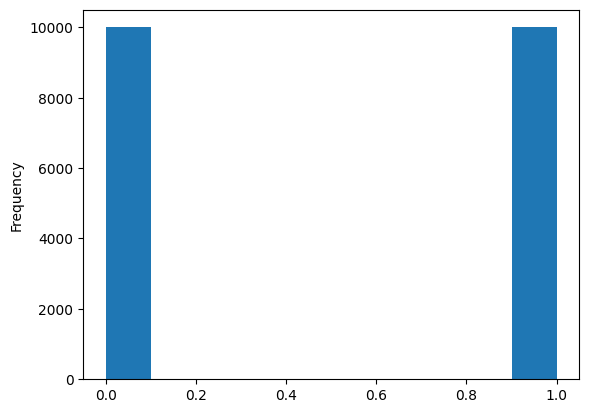

In [8]:
processed_df["label"].plot(kind='hist')

### Train

In [10]:
results = mf.train(net, train_dl, valid_dl, test_dl, config)

Training:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch 1:   0%|          | 0/251 [00:00<?, ? train batch/s]

Training:  10%|█         | 1/10 [05:19<47:51, 319.06s/epoch]

Epoch 2:   0%|          | 0/251 [00:00<?, ? train batch/s]

--- Evaluation at iteration 2 ---


Evaluation:   0%|          | 0/251 [00:00<?, ? Train batch/s]

	Train set: Loss: 0.1955, Acc: 92.39%, Balanced Acc: 92.39%, F1: 0.9218, MCC: 0.8491


Evaluation:   0%|          | 0/32 [00:00<?, ? Validation batch/s]

	Validation set: Loss: 0.2032, Acc: 92.57%, Balanced Acc: 92.58%, F1: 0.9245, MCC: 0.8522


Evaluation:   0%|          | 0/31 [00:00<?, ? Test batch/s]

Training:  20%|██        | 2/10 [16:03<1:08:05, 510.69s/epoch]

	Test set: Loss: 0.2019, Acc: 91.92%, Balanced Acc: 91.88%, F1: 0.9156, MCC: 0.8398
Allocated memory: 0.18 GB
Cached memory:    11.57 GB


Epoch 3:   0%|          | 0/251 [00:00<?, ? train batch/s]

Training:  30%|███       | 3/10 [21:22<49:20, 422.99s/epoch]  

Epoch 4:   0%|          | 0/251 [00:00<?, ? train batch/s]

--- Evaluation at iteration 4 ---


Evaluation:   0%|          | 0/251 [00:00<?, ? Train batch/s]

	Train set: Loss: 0.1716, Acc: 93.47%, Balanced Acc: 93.47%, F1: 0.9365, MCC: 0.8708


Evaluation:   0%|          | 0/32 [00:00<?, ? Validation batch/s]

	Validation set: Loss: 0.2058, Acc: 92.67%, Balanced Acc: 92.67%, F1: 0.9288, MCC: 0.8545


Evaluation:   0%|          | 0/31 [00:00<?, ? Test batch/s]

Training:  40%|████      | 4/10 [32:07<51:03, 510.52s/epoch]

	Test set: Loss: 0.1921, Acc: 92.53%, Balanced Acc: 92.55%, F1: 0.9260, MCC: 0.8514
Allocated memory: 0.18 GB
Cached memory:    11.57 GB


Epoch 5:   0%|          | 0/251 [00:00<?, ? train batch/s]

Training:  50%|█████     | 5/10 [37:25<36:46, 441.34s/epoch]

Epoch 6:   0%|          | 0/251 [00:00<?, ? train batch/s]

--- Evaluation at iteration 6 ---


Evaluation:   0%|          | 0/251 [00:00<?, ? Train batch/s]

	Train set: Loss: 0.1302, Acc: 94.93%, Balanced Acc: 94.94%, F1: 0.9478, MCC: 0.9004


Evaluation:   0%|          | 0/32 [00:00<?, ? Validation batch/s]

	Validation set: Loss: 0.1617, Acc: 93.88%, Balanced Acc: 93.89%, F1: 0.9374, MCC: 0.8788


Evaluation:   0%|          | 0/31 [00:00<?, ? Test batch/s]

Training:  60%|██████    | 6/10 [48:10<34:01, 510.49s/epoch]

	Test set: Loss: 0.1613, Acc: 93.84%, Balanced Acc: 93.80%, F1: 0.9355, MCC: 0.8785
Allocated memory: 0.18 GB
Cached memory:    11.57 GB


Epoch 7:   0%|          | 0/251 [00:00<?, ? train batch/s]

Training:  70%|███████   | 7/10 [53:29<22:23, 447.77s/epoch]

Epoch 8:   0%|          | 0/251 [00:00<?, ? train batch/s]

--- Evaluation at iteration 8 ---


Evaluation:   0%|          | 0/251 [00:00<?, ? Train batch/s]

	Train set: Loss: 0.1206, Acc: 95.32%, Balanced Acc: 95.32%, F1: 0.9548, MCC: 0.9087


Evaluation:   0%|          | 0/32 [00:00<?, ? Validation batch/s]

	Validation set: Loss: 0.2009, Acc: 92.67%, Balanced Acc: 92.66%, F1: 0.9303, MCC: 0.8573


Evaluation:   0%|          | 0/31 [00:00<?, ? Test batch/s]

Training:  80%|████████  | 8/10 [1:04:13<17:00, 510.37s/epoch]

	Test set: Loss: 0.1815, Acc: 93.23%, Balanced Acc: 93.28%, F1: 0.9344, MCC: 0.8680
Allocated memory: 0.18 GB
Cached memory:    11.57 GB


Epoch 9:   0%|          | 0/251 [00:00<?, ? train batch/s]

Training:  90%|█████████ | 9/10 [1:09:32<07:30, 450.46s/epoch]

Epoch 10:   0%|          | 0/251 [00:00<?, ? train batch/s]

--- Evaluation at iteration 10 ---


Evaluation:   0%|          | 0/251 [00:00<?, ? Train batch/s]

	Train set: Loss: 0.0484, Acc: 98.56%, Balanced Acc: 98.56%, F1: 0.9857, MCC: 0.9713


Evaluation:   0%|          | 0/32 [00:00<?, ? Validation batch/s]

	Validation set: Loss: 0.1250, Acc: 95.23%, Balanced Acc: 95.23%, F1: 0.9527, MCC: 0.9047


Evaluation:   0%|          | 0/31 [00:00<?, ? Test batch/s]

Training: 100%|██████████| 10/10 [1:20:17<00:00, 481.74s/epoch]

	Test set: Loss: 0.1183, Acc: 95.40%, Balanced Acc: 95.41%, F1: 0.9538, MCC: 0.9082
Allocated memory: 0.18 GB
Cached memory:    11.57 GB


### Plot


=== Final Evaluation Metrics ===
Train   -> Loss: 0.0484, Accuracy: 98.56%
Valid   -> Loss: 0.1250, Accuracy: 95.23%
Test    -> Loss: 0.1183, Accuracy: 95.40%


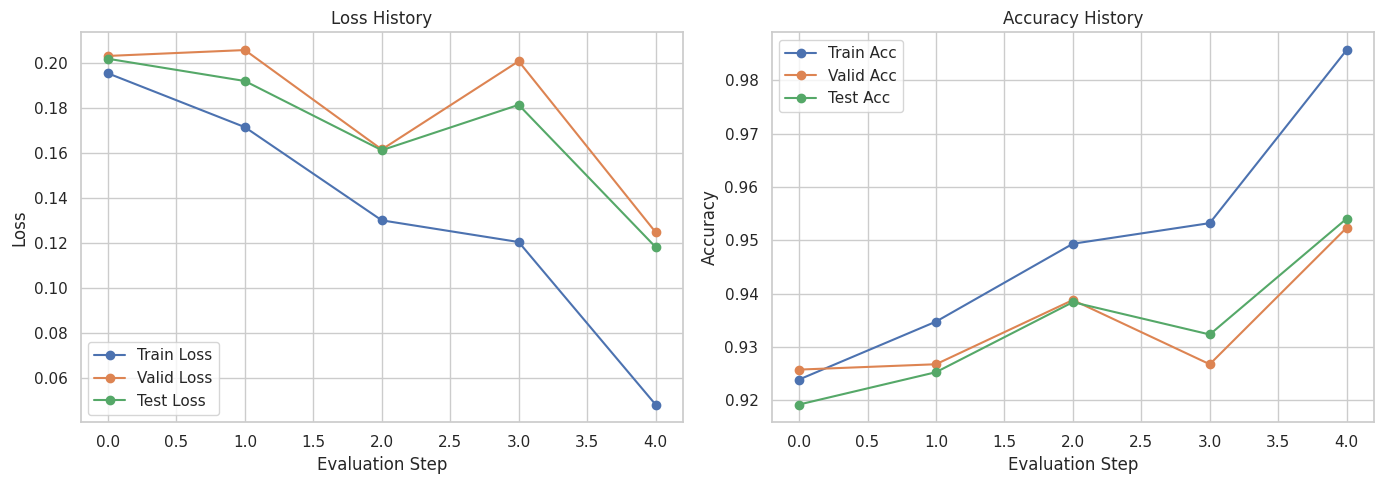

In [11]:
mf.summarize_training(*results)

### Save Model

In [17]:
torch.save(net, config["PATH_TO_SAVE_MODEL"])

### Load Model

In [ ]:
net = torch.load(config["PATH_TO_SAVE_MODEL"])
net.eval()

/tmp/ipykernel_5960/3766833804.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net = torch.load(config["PATH_TO_SAVE_MODEL"])


EsmDeepSec(
  (esm_model): EsmModel(
    (embeddings): EsmEmbeddings(
      (word_embeddings): Embedding(33, 320, padding_idx=1)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): EsmEncoder(
      (layer): ModuleList(
        (0-5): 6 x EsmLayer(
          (attention): EsmAttention(
            (self): EsmSelfAttention(
              (query): Linear(in_features=320, out_features=320, bias=True)
              (key): Linear(in_features=320, out_features=320, bias=True)
              (value): Linear(in_features=320, out_features=320, bias=True)
              (rotary_embeddings): RotaryEmbedding()
            )
            (output): EsmSelfOutput(
              (dense): Linear(in_features=320, out_features=320, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (LayerNorm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
          )
          (intermediate): EsmIntermediate(
            (dense): Linear(in_features=320, out_fe

### Umaps

Many types of embeddings can be extracted from different moments inside the model:

**1. From the ESM backbone**
- **ESM mean** → mean pooling over all token embeddings.  
- **ESM max** → max pooling over all token embeddings.  
- **ESM CLS** → embedding of the special classification token (first position).  
- **ESM tokens** → full sequence of token-level embeddings `[batch, seq_len, hidden_dim]`.  
- (Optional) **Layerwise embeddings** → extracting hidden states from multiple layers (e.g. last 4).

**2. From the feature head (AttentionClassificationHead)**
- **Feature mean** → mean pooling after attention + FFNN.  
- **Feature max** → max pooling after attention + FFNN.  
- **Feature CLS** → CLS token representation after attention + FFNN.  
- **Feature concat** → concatenation of mean and max pooling (used for classification).  


Extracting embeddings from training set...



Batch:   0%|          | 0/32 [00:00<?, ? batch/s]

All possbile embedding given current model architecrure:
esm_mean: (4007, 320)
esm_max: (4007, 320)
esm_csl: (4007, 320)

Computing UMAP embeddings...

Computing UMAP for esm_mean with shape (4007, 320)...
Computing UMAP for esm_max with shape (4007, 320)...
Computing UMAP for esm_csl with shape (4007, 320)...

Plotting UMAP embeddings...



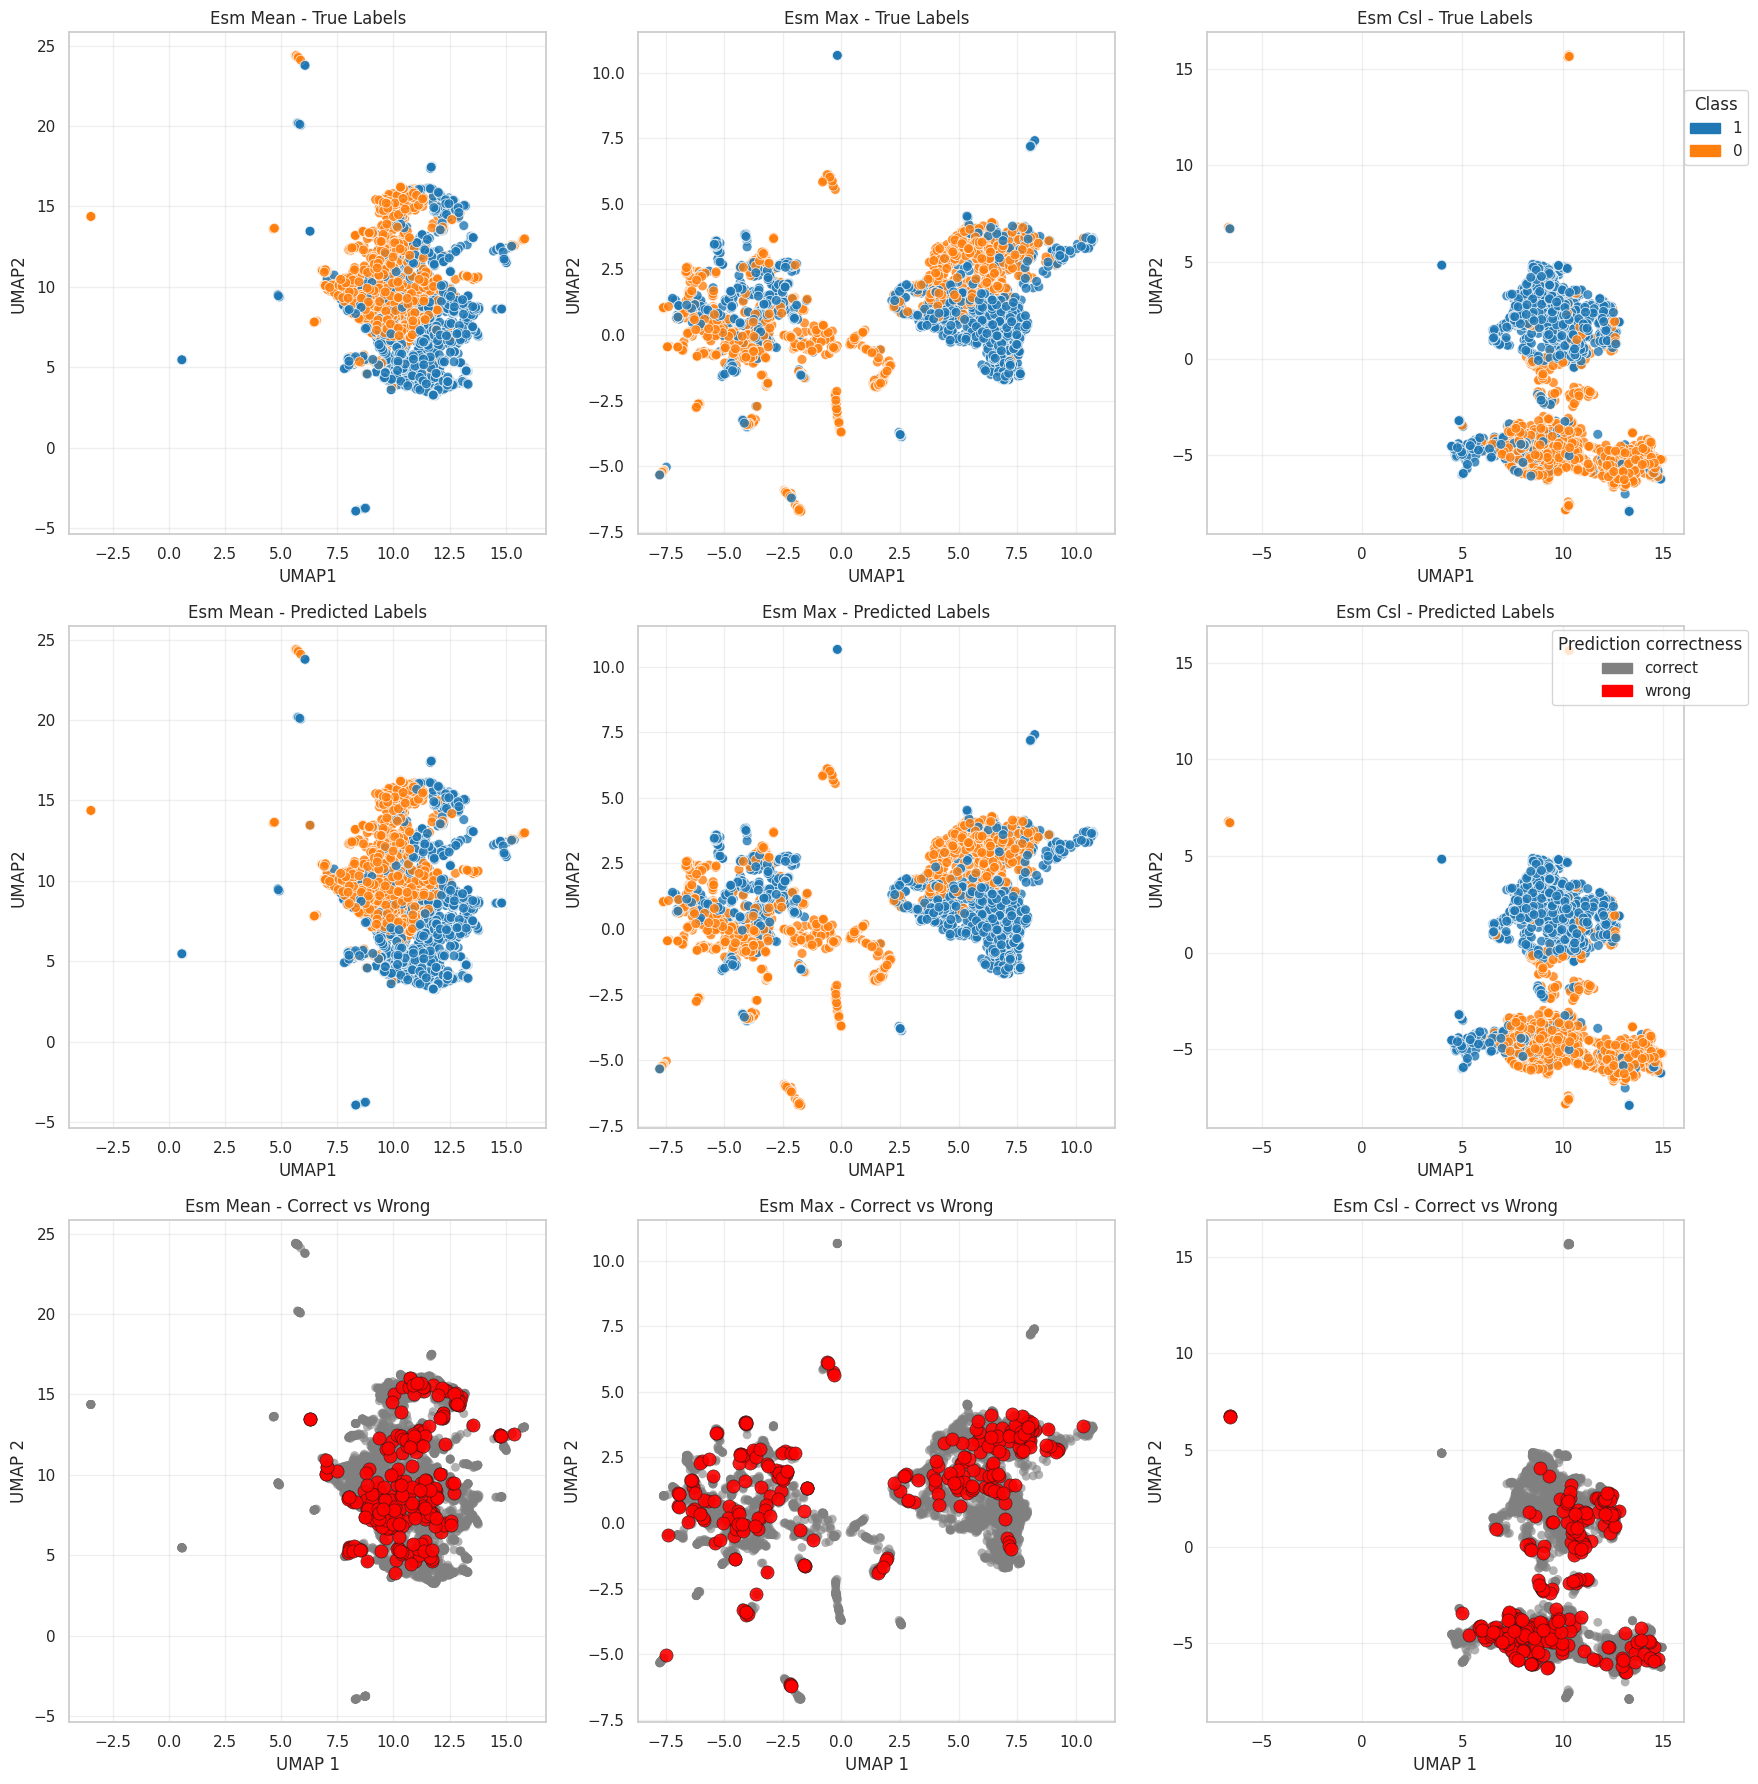

{'esm_mean':         Name      UMAP1      UMAP2 TrueClass PredClass CorrectStr
 0     O15213   8.773555  13.383717         0         0    correct
 1     Q9NQZ3  15.283511  12.563904         0         0    correct
 2     Q9H4T2   8.578589  10.943988         0         0    correct
 3     Q5TEJ8   9.363185  11.225492         0         0    correct
 4     Q8IYA6   9.529400  13.000768         0         0    correct
 ...      ...        ...        ...       ...       ...        ...
 4002  Q969X6   8.927892  13.365618         0         0    correct
 4003  O15527  10.609295   9.289209         0         0    correct
 4004  P0C862  14.927517  11.730450         1         1    correct
 4005  Q15111  10.430550  15.494346         0         0    correct
 4006  Q68D91  11.349286   9.120762         0         0    correct
 
 [4007 rows x 6 columns],
 'esm_max':         Name     UMAP1     UMAP2 TrueClass PredClass CorrectStr
 0     O15213 -3.124453  2.728087         0         0    correct
 1     Q9NQZ3  

In [ ]:
DATALOADER = train_dl

#############################
###### EXTRACT EMBEDDINGS
#############################

print("\nExtracting embeddings from training set...\n")

# Extract embeddings
train_embeddings, names, labels, predictions = mf.extract_embeddings(
    net=net,
    dl=train_dl,
    device=config["DEVICE"],
    return_numpy=True # set to False if you want torch tensors instead
)

print("All possbile embedding given current model architecrure:")
# Example: check shapes
for key, emb in train_embeddings.items():
    print(f"{key}: {emb.shape}")

#############################
###### CALCULATE UMAP
#############################

print("\nComputing UMAP embeddings...\n")

umap_tensors = mf.compute_umap_tensors( #dict of tensors
    embeddings_dict=train_embeddings,
)

#############################
###### PLOT
#############################

print("\nPlotting UMAP embeddings...\n")

df = mf.plot_umap_embeddings(umap_tensors, names, labels, predictions)


Extracting embeddings from training set...



Batch:   0%|          | 0/251 [00:00<?, ? batch/s]

All possbile embedding given current model architecrure:
esm_mean: (16027, 320)
esm_max: (16027, 320)
esm_csl: (16027, 320)
class_head_embs_class_head_mean: (16027, 320)
class_head_embs_class_head_max: (16027, 320)
class_head_embs_class_head_cls: (16027, 320)

Computing UMAP embeddings...

Computing UMAP for esm_mean with shape (16027, 320)...
Computing UMAP for esm_max with shape (16027, 320)...
Computing UMAP for esm_csl with shape (16027, 320)...
Computing UMAP for class_head_embs_class_head_mean with shape (16027, 320)...
Computing UMAP for class_head_embs_class_head_max with shape (16027, 320)...
Computing UMAP for class_head_embs_class_head_cls with shape (16027, 320)...

Plotting UMAP embeddings...



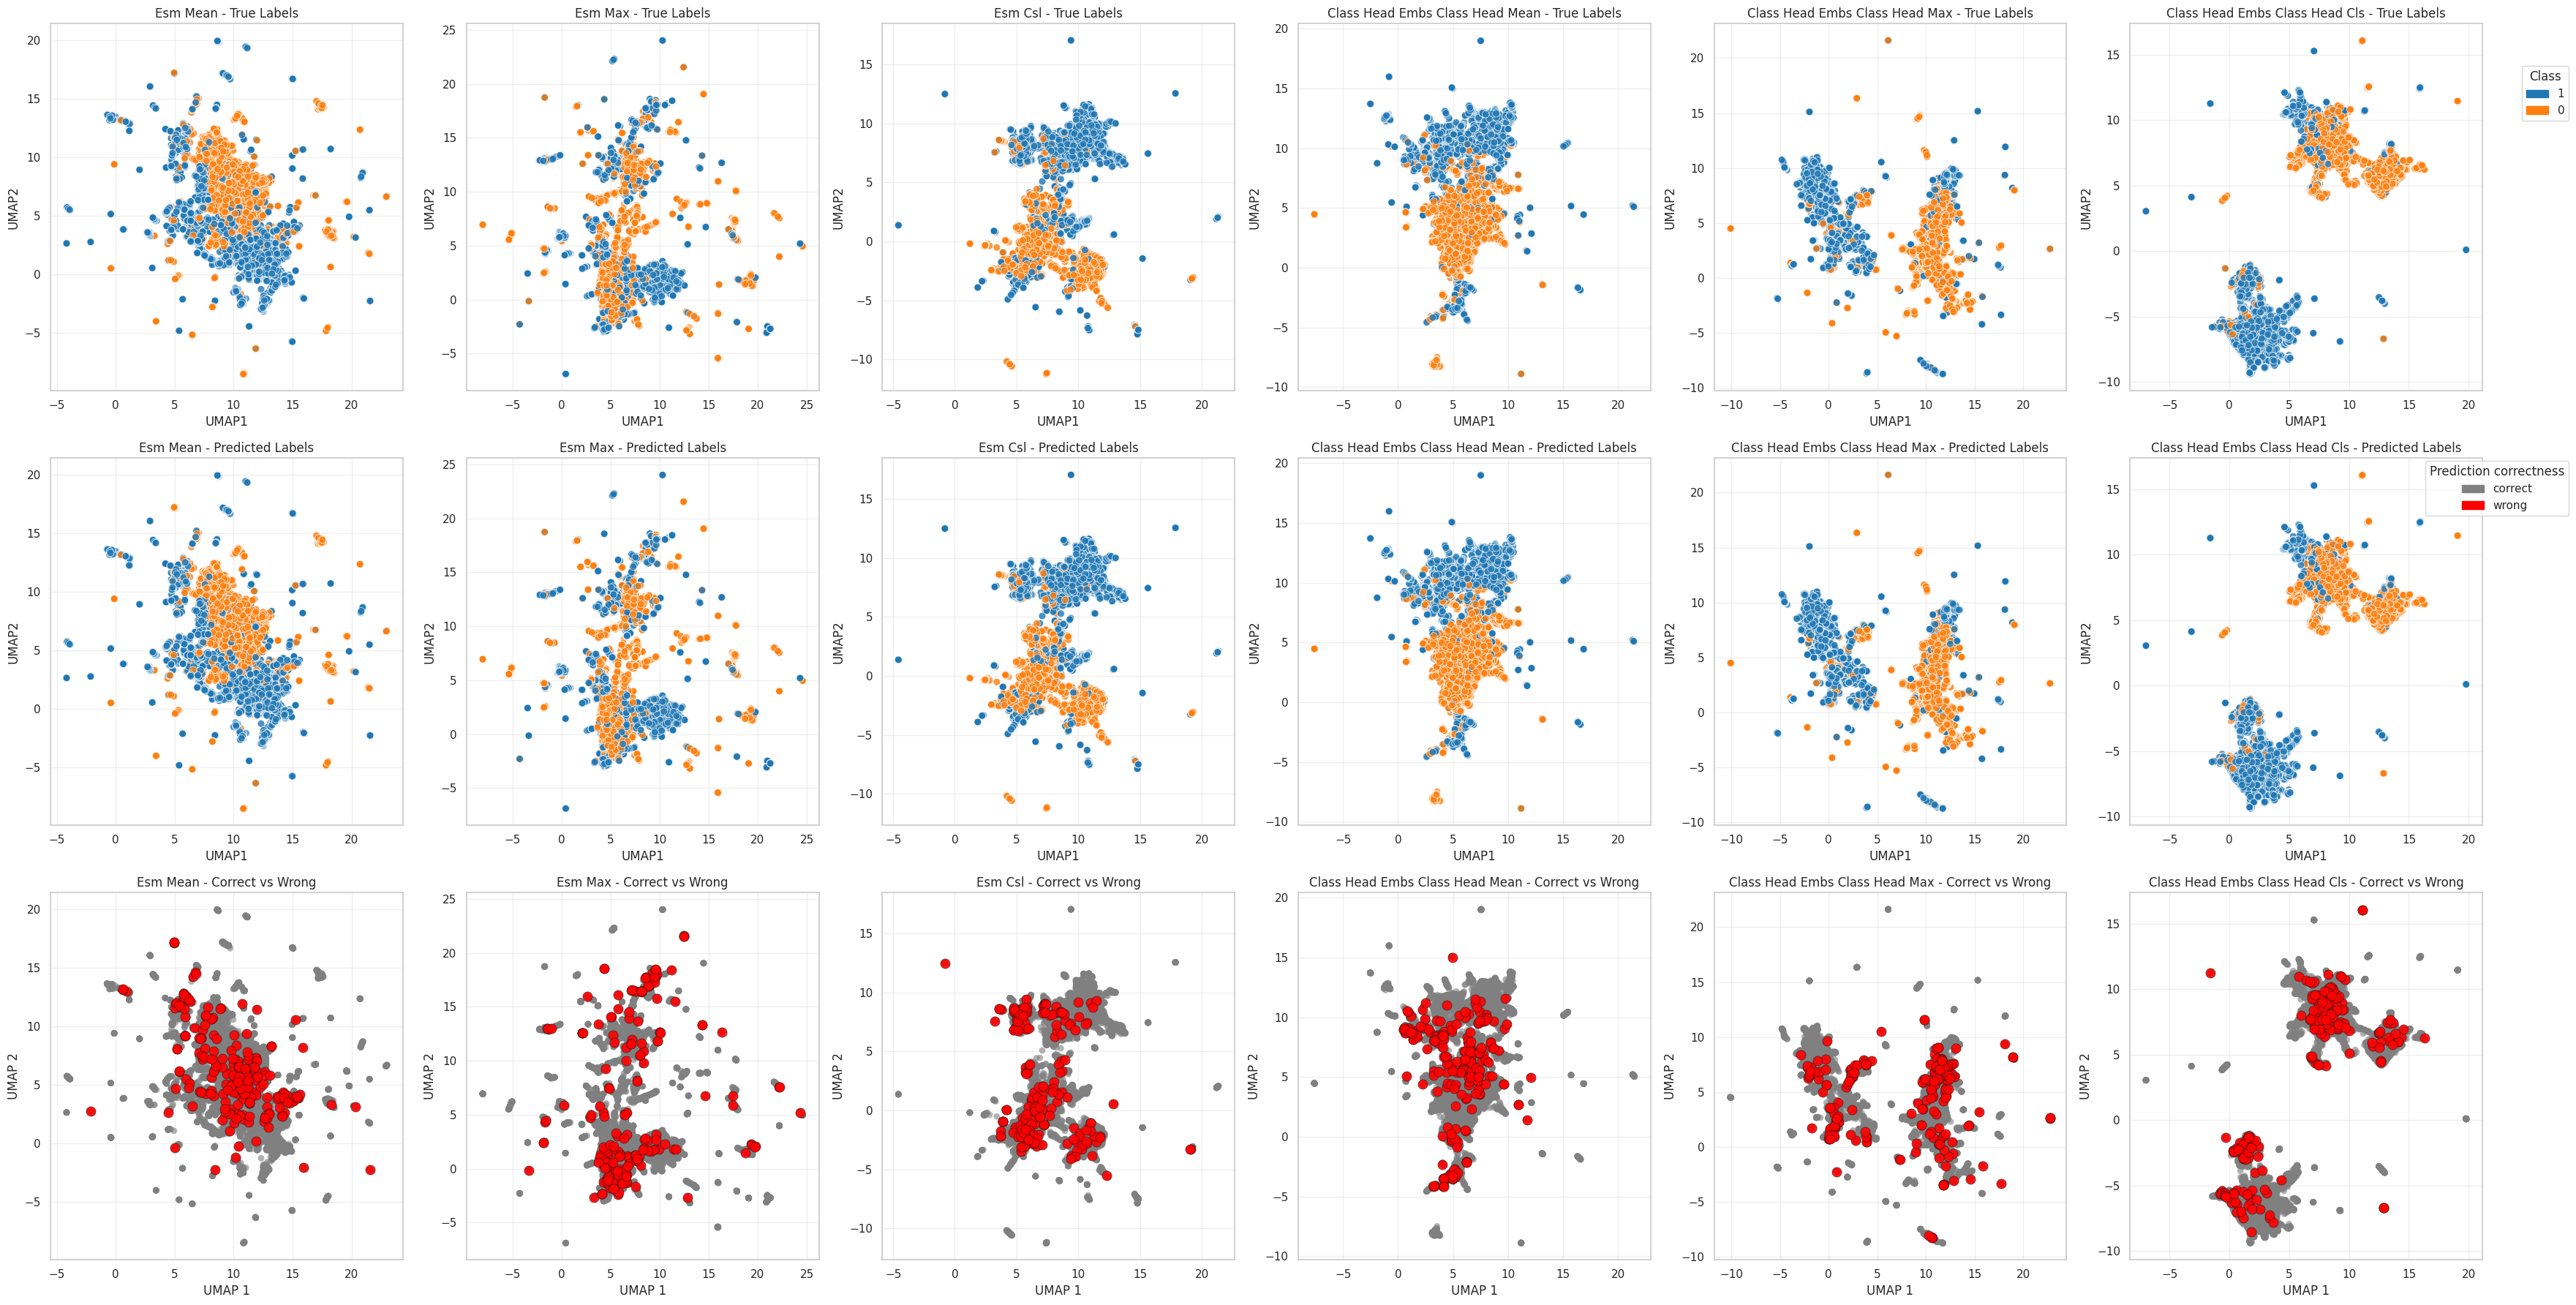

In [12]:
DATALOADER = test_dl

#############################
###### EXTRACT EMBEDDINGS
#############################

print("\nExtracting embeddings from training set...\n")

# Extract embeddings
train_embeddings, names, labels, predictions = mf.extract_embeddings(
    net=net,
    dl=train_dl,
    device=config["DEVICE"],
    return_numpy=True # set to False if you want torch tensors instead
)

print("All possbile embedding given current model architecrure:")
# Example: check shapes
for key, emb in train_embeddings.items():
    print(f"{key}: {emb.shape}")

#############################
###### CALCULATE UMAP
#############################

print("\nComputing UMAP embeddings...\n")

umap_tensors = mf.compute_umap_tensors( #dict of tensors
    embeddings_dict=train_embeddings,
)

#############################
###### PLOT
#############################

print("\nPlotting UMAP embeddings...\n")

df = mf.plot_umap_embeddings(umap_tensors, names, labels, predictions)

In [13]:
df["esm_mean"][(df["esm_mean"]["CorrectStr"] == "correct") & (df["esm_mean"]["TrueClass"] == "1")]

#df[df['CorrectStr'] == 'correct']


,Name,UMAP1,UMAP2,TrueClass,PredClass,CorrectStr
0,Q91VU0,10.101485,1.770128,1,1,correct
3,P61095,12.434484,-2.926151,1,1,correct
4,P62940,10.522560,3.397601,1,1,correct
5,P13726,14.547970,3.438719,1,1,correct
6,P50591,10.696095,5.165021,1,1,correct
...,...,...,...,...,...,...
16015,Q8N2S1,5.184823,11.477176,1,1,correct
16016,P51918,13.020011,1.246342,1,1,correct
16021,Q29016,8.361225,4.299192,1,1,correct
16022,C0JAZ9,4.335491,5.394639,1,1,correct


### A-scanning

sequence                    MLLLPLLPVLLCVVSVSSSGSQTCEDTLKTCSVIACGRDGRDGPKG...
trunc_sequence              MLLLPLLPVLLCVVSVSSSGSQTCEDTLKTCSVIACGRDGRDGPKG...
input_ids                   [tensor(0), tensor(20), tensor(4), tensor(4), ...
attention_mask              [tensor(1), tensor(1), tensor(1), tensor(1), t...
label                                                                       1
protein                                                                P39039
sequence_length                                                           239
trunc_sequence_length                                                     239
inputs_ids_length                                                        1000
inputs_ids_length_no_pad                                                  241
set                                                                     train
Name: 3259, dtype: object

3


Evaluation:   0%|          | 0/1 [00:00<?, ? Single protein batch/s]

Generating mutations:   0%|          | 0/239 [00:00<?, ?it/s]

Preprocessing mutations:   0%|          | 0/956 [00:00<?, ?it/s]

Evaluating model on mutated sequences...


Evaluation:   0%|          | 0/107 [00:00<?, ? Multi-AA Scan batch/s]

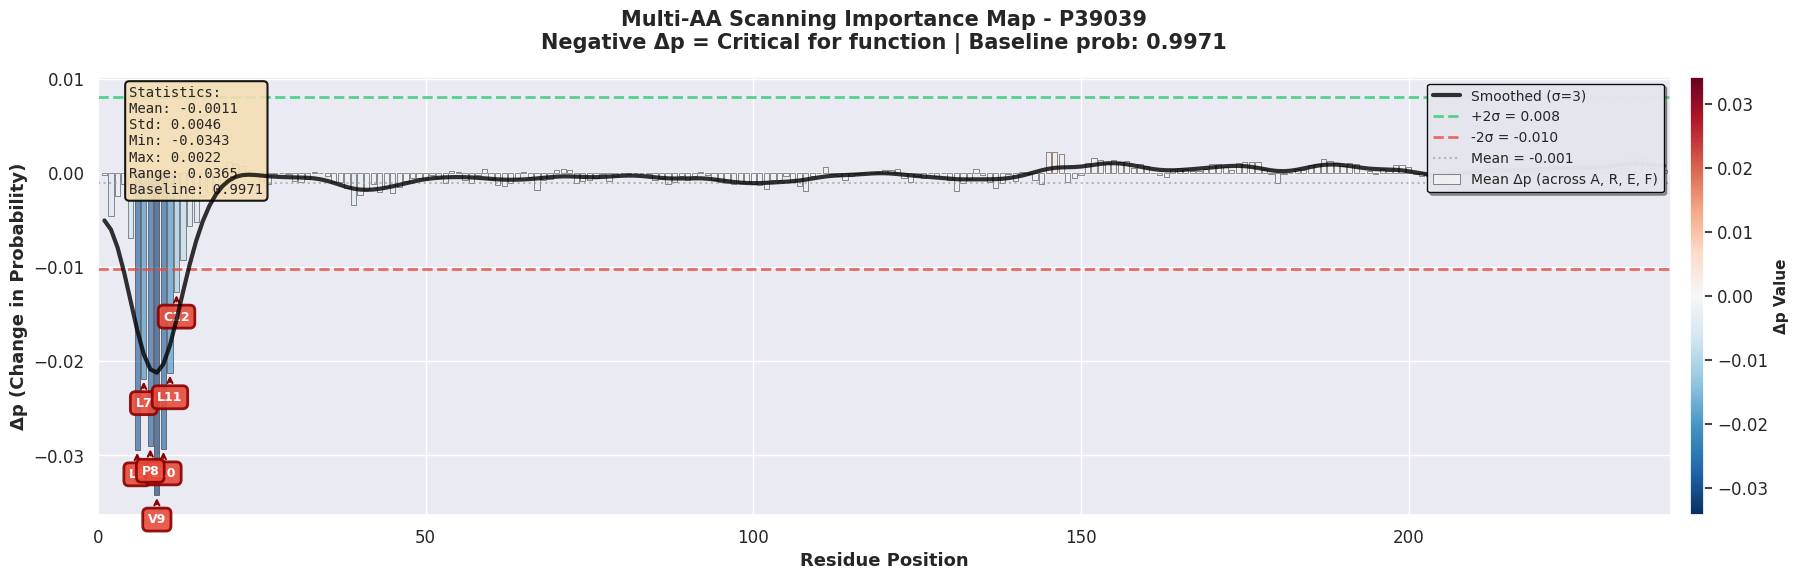


                      MULTI-AA SCANNING SUMMARY                       

Sequence Information:         
  Length:                   239
  Protein:                  P39039
  Substitute AAs:           A, R, E, F
  Baseline Probability:     0.9971

Statistical Summary:          
  Mean Δp:                  -0.0011
  Std Δp:                   0.0046
  Min Δp:                   -0.0343
  Max Δp:                   0.0022
  Threshold (+2σ):          0.0081
  Threshold (-2σ):          -0.0102

──────────────────────────────────────────────────────────────────────
             TOP CRITICAL RESIDUES (Largest Negative Δp)              
──────────────────────────────────────────────────────────────────────
Rank    Position    Residue     Δp             Status              
──────────────────────────────────────────────────────────────────────
1       9           V           -0.0343        ⚠️  Beyond threshold
2       6           L           -0.0295        ⚠️  Beyond threshold
3       10          L

In [19]:
PROTEIN = "P39039" # "Q91VU0"
WINDOW_SIZE_FRACTION = 0.01 # 10% of sequence length
SUBSTITUTE_AA = "A" #"<pad>", "A", "P"

# Extract info
single_protein_info = processed_df[processed_df['protein'] == PROTEIN].iloc[0]
display(single_protein_info)

WINDOW_SIZE_SUBSTITUION = int(single_protein_info.trunc_sequence_length * WINDOW_SIZE_FRACTION // 2 * 2 + 1) # make it odd
print(WINDOW_SIZE_SUBSTITUION)

scan_results = mf.multi_aa_scanning(net, tokenizer, 
                      single_protein_info, 
                      window_size=WINDOW_SIZE_SUBSTITUION, 
                      substitute_aas=["A", "R", "E", "F"],
                      normalise_true_substitution=False,
                      device=config["DEVICE"])

mf.plot_multi_aa_scan(scan_results, show_per_aa=False)

# AAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
# AAAAAAAAAAAAAAAAAAAAAAAAAAAAAA

### A-scanning Logits

sequence                    MMANWAEARPLLILIVLLGQFVSIKAQEEDEDEGYGEEIACTQNGQ...
trunc_sequence              MMANWAEARPLLILIVLLGQFVSIKAQEEDEDEGYGEEIACTQNGQ...
input_ids                   [tensor(0), tensor(20), tensor(20), tensor(5),...
attention_mask              [tensor(1), tensor(1), tensor(1), tensor(1), t...
label                                                                       1
protein                                                                P05997
sequence_length                                                          1499
trunc_sequence_length                                                    1000
inputs_ids_length                                                        1000
inputs_ids_length_no_pad                                                 1000
set                                                                     train
Name: 71, dtype: object

11


Evaluation:   0%|          | 0/1 [00:00<?, ? Single protein batch/s]

Generating mutations:   0%|          | 0/1000 [00:00<?, ?it/s]

Preprocessing mutations:   0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating model on mutated sequences...


Evaluation:   0%|          | 0/100 [00:00<?, ? Batch Mutation Scan batch/s]

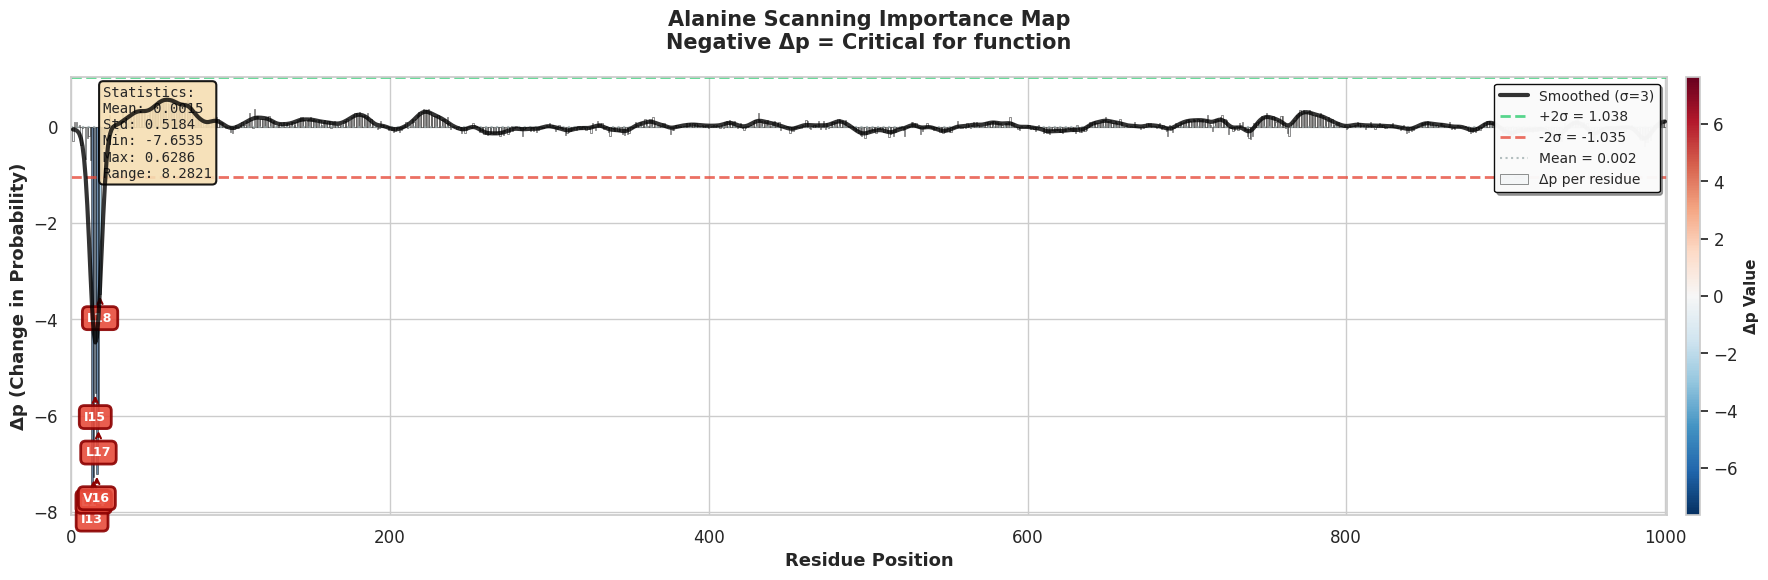


                       ALANINE SCANNING SUMMARY                       

Sequence Information:         
  Length:                   1000
  Protein:                  P05997

Statistical Summary:          
  Mean Δp:                  0.0015
  Std Δp:                   0.5184
  Min Δp:                   -7.6535
  Max Δp:                   0.6286
  Threshold (+2σ):          1.0384
  Threshold (-2σ):          -1.0354

──────────────────────────────────────────────────────────────────────
             TOP CRITICAL RESIDUES (Largest Negative Δp)              
──────────────────────────────────────────────────────────────────────
Rank    Position    Residue     Δp             Status              
──────────────────────────────────────────────────────────────────────
1       13          I           -7.6535        ⚠️  Beyond threshold
2       14          L           -7.2835        ⚠️  Beyond threshold
3       16          V           -7.2097        ⚠️  Beyond threshold
4       17          L      

In [ ]:
def prob_to_logit(p):
    """
    Convert probability of class 1 to logit (binary case)
    p: float or np.array of probabilities (0 < p < 1)
    returns: logit value(s)
    """
    p = np.clip(p, 1e-15, 1 - 1e-15)  # avoid log(0)
    return np.log(p / (1 - p))


PROTEIN = "P05997" #"Q6ZRI0" #"P01270" #"O60938" #"P05997"
WINDOW_SIZE_FRACTION = 0.01 # 10% of sequence length
SUBSTITUTE_AA = "A" #"<pad>", "A", "P"

# Extract info
single_protein_info = processed_df[processed_df['protein'] == PROTEIN].iloc[0]
display(single_protein_info)

WINDOW_SIZE_SUBSTITUION = int(single_protein_info.trunc_sequence_length * WINDOW_SIZE_FRACTION // 2 * 2 + 1) # make it odd
print(WINDOW_SIZE_SUBSTITUION)

# Run alanine scanning
results = mf.alanine_scanning(
    model=net,
    tokenizer=tokenizer,
    single_protein_info=single_protein_info,
    window_size=WINDOW_SIZE_SUBSTITUION, # make it odd
    device=config["DEVICE"],
    SUBSTITUTE_AA=SUBSTITUTE_AA,
    normalise_true_substitution=True #normalise by number of true substitutions (not A->A
)

# calcuate logits
baseline_logit = prob_to_logit(results['baseline_prob'])
mutated_logits = prob_to_logit(results['mutated_probs'])
delta_logit = mutated_logits - baseline_logit

mf.plot_alanine_scan(
    delta_p=delta_logit,
    sequence=results['sequence'],
    protein_name=results['protein_name'],
    sigma=3,
    threshold=True,
    highlight_residues=True,
    top_n=10,
    show_sequence=False,
    style='whitegrid'  # Options: 'darkgrid', 'whitegrid', 'dark', 'white', 'ticks'
)

### Random prot

In [ ]:
random_prot = "MVMAAAKKNMQQLDSFKGDDSIDHEIATPYSWQRKFSGESKAIALGMYGTKMISCGQWRDQACYILYWVFWYPYFNVSQESIVLQYDLPHYGYDIFKPYINQTARCCPHHPQEAMNSEGNTVPACYAAVGQADPPIFDIAYSIMILRPLYGTCNPTGFQNVMNAIWSEEMAMFTQTHYVLPYRYPYQTYRLTSFSSRIMMENAGACEWESMVNFIFRTVAKRCKDKEYLFGNCAWTRLWSIAPHQWKWPSKNTHMYIDHFVEKGKQEELSNASWHTYLATSICPAHHHDWVWWNFEFWLCHFTEMDT"
random_label = 0
random_name = "Random_Prot"
random_data = pd.DataFrame([{
    'sequence': random_prot,
    'label': random_label,
    'protein': random_name,
    'set': 'test'
}])

# Preprocess each sequence individually
random_preprocessed_data = []
for idx, row in tqdm(random_data.iterrows(), total=len(random_data)):
    processed = my_dataset.preprocess_sequence(
        sequence=row['sequence'],
        label=row['label'],
        protein_name=row['protein'],
        tokenizer=tokenizer,
        protein_max_length=config["PROTEIN_MAX_LENGTH"]
    )
    random_preprocessed_data.append(processed)

# Create DataFrame from preprocessed data
random_processed_df = pd.DataFrame(random_preprocessed_data)

# Add the 'set' column back from original data
random_processed_df['set'] = random_data['set'].values

############################################

random_dl = my_dataset.create_dataloader(random_processed_df, 'test', config["BATCH_SIZE"], shuffle=True)

# Optional: inspect the DataFrame
display(random_processed_df.head(5))
#print(random_processed_df.loc[0, "input_ids"])

100%|██████████| 1/1 [00:00<00:00, 337.35it/s]

,sequence,trunc_sequence,input_ids,attention_mask,label,protein,sequence_length,trunc_sequence_length,inputs_ids_length,inputs_ids_length_no_pad,set
0,MVMAAAKKNMQQLDSFKGDDSIDHEIATPYSWQRKFSGESKAIALG...,MVMAAAKKNMQQLDSFKGDDSIDHEIATPYSWQRKFSGESKAIALG...,"[tensor(0), tensor(20), tensor(7), tensor(20),...","[tensor(1), tensor(1), tensor(1), tensor(1), t...",0,Random_Prot,307,307,1000,309,test


In [ ]:
outputs = mf.evaluate_model(net, random_dl, config["DEVICE"], loss_fn=None, split_name="Eval", verbose=True)
outputs

Evaluation:   0%|          | 0/1 [00:00<?, ? Eval batch/s]

	Eval set: Loss: 0.6502, Acc: 100.00%, Balanced Acc: 100.00%, F1: 1.0000, MCC: 0.0000


/home/gdallagl/.pyenv/versions/esm2_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/home/gdallagl/.pyenv/versions/esm2_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


{'loss': 0.6502161622047424,
 'accuracy': 1.0,
 'balanced_accuracy': 1.0,
 'f1': 1.0,
 'mcc': 0.0,
 'probs': tensor([[0.5219, 0.4781]]),
 'probs_class1': tensor([0.4781]),
 'labels': tensor([0]),
 'pred_labels': tensor([0])}

### Calibration

In [ ]:
outputs = mf.evaluate_model(net, test_dl, config["DEVICE"], loss_fn=None, split_name="Eval", verbose=True)
outputs

Evaluation:   0%|          | 0/16 [00:00<?, ? Eval batch/s]

	Eval set: Loss: 0.1352, Acc: 95.40%, Balanced Acc: 95.41%, F1: 0.9539, MCC: 0.9083


{'loss': 0.13518396019935608,
 'accuracy': 0.9540404677391052,
 'balanced_accuracy': 0.9541499822441007,
 'f1': 0.9539240506329114,
 'mcc': 0.9082559409691222,
 'probs': tensor([[7.5312e-06, 9.9999e-01],
         [9.6241e-01, 3.7587e-02],
         [1.4507e-05, 9.9999e-01],
         ...,
         [9.9676e-01, 3.2376e-03],
         [9.6076e-01, 3.9241e-02],
         [9.9948e-01, 5.2211e-04]]),
 'probs_class1': tensor([9.9999e-01, 3.7587e-02, 9.9999e-01,  ..., 3.2376e-03, 3.9241e-02,
         5.2211e-04]),
 'labels': tensor([1, 1, 1,  ..., 0, 0, 0]),
 'pred_labels': tensor([1, 0, 1,  ..., 0, 0, 0])}

tensor([9.9999e-01, 3.7587e-02, 9.9999e-01,  ..., 3.2376e-03, 3.9241e-02,
        5.2211e-04])


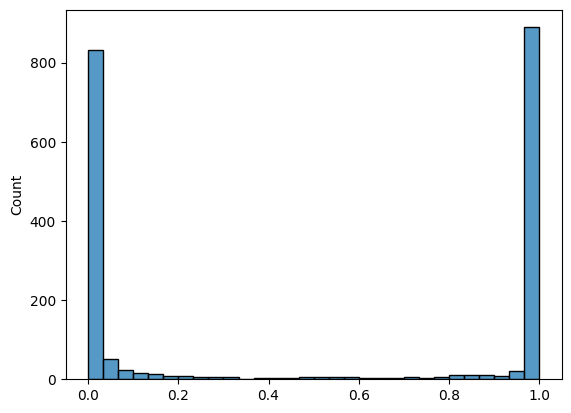

In [ ]:
probs = outputs['probs_class1']
print(probs)
sns.histplot(probs, kde=False, bins=30)  # kde=True if you also want a density curve
plt.show()

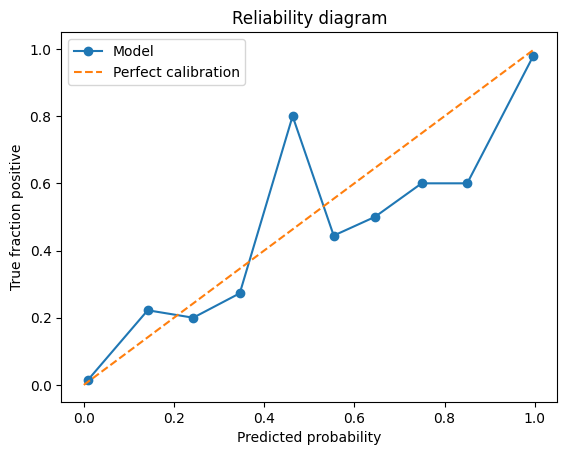

In [ ]:
# Calibration curve

from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

# y_true: 0 or 1 labels for your proteins
# y_prob: predicted probabilities for class 1

#x-axis = average predicted probability in that bin.
#y-axis = true fraction positive in that bin.

prob_true, prob_pred = calibration_curve(y_true=outputs['labels'], y_prob=outputs['probs_class1'], n_bins=10)

plt.plot(prob_pred, prob_true, marker='o', label="Model")
plt.plot([0,1],[0,1], linestyle="--", label="Perfect calibration")
plt.xlabel("Predicted probability")
plt.ylabel("True fraction positive")
plt.title("Reliability diagram")
plt.legend()
plt.show()
